# Compare Llama3.1 8B Instruct quantizations VS ChatGPT 4o

So for this task i asked ChatGPT 4o to give me 5 questions for RAG system (there is a context with question) and get a answer based on the instructions that we are gonna get to the Llama 3.1 quantizations.

We compare them based on the cosine similarity of each answers. We use lm-studio to run the models.

The template that meta has released for their Instruct models is like this:


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

<|eot_id|><|start_header_id|>user<|end_header_id|>

<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Lets save the Q&A with their context of ChatGPT 4o in a dictionary 

In [1]:
gpt_data = {
    0: {
        "context": " برج ایفل، یکی از معروف‌ترین نشانه‌های دنیا، در شهر پاریس فرانسه قرار دارد. این برج بین سال‌های ۱۸۸۷ تا ۱۸۸۹ به عنوان ورودی نمایشگاه جهانی ۱۸۸۹ ساخته شد.",
        "question": " برج ایفل در کدام شهر واقع شده است؟",
        "answer": " پاریس.",
    },
    1: {
        "context": "آلبرت اینشتین، فیزیکدان نظری، نظریه نسبیت را توسعه داد که یکی از دو ستون فیزیک مدرن است (ستون دیگر مکانیک کوانتومی است). کار او همچنین تأثیر زیادی بر فلسفه علم داشت.",
        "question": " چه کسی نظریه نسبیت را توسعه داد؟",
        "answer": "آلبرت اینشتین.",
        
    },
    2: {
        "context": " جنگل‌های آمازون، که اغلب به عنوان `ریه‌های زمین` شناخته می‌شوند، بزرگترین جنگل‌های استوایی در جهان هستند و بیشتر بخش‌های شمالی آمریکای جنوبی را پوشش می‌دهند. این جنگل‌ها محل زندگی گونه‌های متنوعی از گیاهان و جانوران هستند.",
        "question": "جنگل‌های آمازون به چه نامی شناخته می‌شوند؟",
        "answer": "ریه‌های زمین.",
    },
    3: {
        "context": "دیوار بزرگ چین که طی چندین سلسله ساخته شده است، ابتدا برای محافظت از ایالت‌ها و امپراتوری‌های چین در برابر تهاجمات و حملات گروه‌های کوچ‌نشین از شمال ساخته شد.",
        "question": " چرا دیوار بزرگ چین در ابتدا ساخته شد؟",
        "answer": "برای محافظت از ایالت‌ها و امپراتوری‌های چین در برابر تهاجمات و حملات گروه‌های کوچ‌نشین از شمال.",
    },
    4: {
        "context": " قلب انسان چهار حفره دارد: دو دهلیز (حفره‌های بالایی) و دو بطن (حفره‌های پایینی). این قلب خون را در سراسر بدن پمپاژ می‌کند و به بافت‌ها اکسیژن و مواد مغذی می‌رساند و دی‌اکسید کربن و دیگر ضایعات را از بدن خارج می‌کند.",
        "question": "قلب انسان چند حفره دارد؟",
        "answer": "چهار حفره.",
    },
}

In this notebook we use langchain python library to create prompt and a chain to have simple implementation.

We use default configuration for connecting to lm-studio.

the response function gives us the response of a specifc llm model and elapsed time that llm spent for a question.

In [2]:
from langchain_openai import OpenAI
from langchain_core.prompts import PromptTemplate
from time import time

prompt_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an intelligent assistant. You always provide well-reasoned answersthat are both correct and helpful. The above history is a conversation between you and a human(if there isn't anything that means a new start). you just need to answer as a assistant with the above instructions.
Instructions:
- Provide only the answer; avoid unnecessary talk or explanations.
- Provide an accurate and thoughtful answer based on the context if the question is related.
- If the question is unrelated or general (like greetings), respond appropriately but without referencing the context.
- If you don't know the answer, simply say I don't know.
Contexts:
{contexts}
<|eot_id|><|start_header_id|>user<|end_header_id|>
{query}
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(prompt_template)

def response(model_name, datas):
    elapsed_times = []
    responses = []
    llm = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio", model=model_name)
    rag_chain = rag_prompt | llm

    for data in datas.values():
        a = time()
        response = rag_chain.invoke({"contexts": data["context"], "query": data["question"]})
        b = time()

        elapsed_times.append(b - a)
        responses.append(response)

    return (elapsed_times, responses)

In [13]:
llm_quantizations_datas = {}

while model_name := input("Enter quantization model name: "):
    if not model_name:
        break
        
    elapsed_time, responses = response(model_name, gpt_data)
    llm_quantizations_datas[model_name] = (elapsed_time, responses)    

Enter quantization model name:  Q3_K_L
Enter quantization model name:  IQ4_XS
Enter quantization model name:  Q4_K_M
Enter quantization model name:  


In [38]:
import pandas as pd

times_df = pd.DataFrame({key: value[0] for key, value in llm_quantizations_datas.items()})
responses_df = pd.DataFrame({key: value[1] for key, value in llm_quantizations_datas.items()})
responses_df

,Q3_K_L,IQ4_XS,Q4_K_M
0,پاریس,پاریس,پاریس فرانسه
1,آلبرت اینشتین,آلبرت اینشتین,آلبرت اینشتین
2,ریه‌های زمین,ریه‌های زمین,ریه‌های زمین
3,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...,برای محافظت از ایالت ها و امپراتوری های چین در...
4,چهار حفره دارد. دو دهلیز و دو بطن.,دویست و شش حفره ندارد. قلب انسان چهار حفره دار...,چهار حفره دارد. دو دهلیز (حفره‌های بالایی) و د...


In [37]:
gpt_answers = pd.DataFrame(gpt_data).T.drop(['context', "question"], axis =1)
gpt_answers

,answer
0,پاریس.
1,آلبرت اینشتین.
2,ریه‌های زمین.
3,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...
4,چهار حفره.


In [48]:
answers_comparison = pd.concat([responses_df, gpt_answers], axis=1)
answers_comparison

,Q3_K_L,IQ4_XS,Q4_K_M,answer
0,پاریس,پاریس,پاریس فرانسه,پاریس.
1,آلبرت اینشتین,آلبرت اینشتین,آلبرت اینشتین,آلبرت اینشتین.
2,ریه‌های زمین,ریه‌های زمین,ریه‌های زمین,ریه‌های زمین.
3,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...,برای محافظت از ایالت ها و امپراتوری های چین در...,برای محافظت از ایالت‌ها و امپراتوری‌های چین در...
4,چهار حفره دارد. دو دهلیز و دو بطن.,دویست و شش حفره ندارد. قلب انسان چهار حفره دار...,چهار حفره دارد. دو دهلیز (حفره‌های بالایی) و د...,چهار حفره.


In [42]:
times_df

,Q3_K_L,IQ4_XS,Q4_K_M
0,5.405515,5.312690,15.736962
1,3.927681,7.271171,13.579491
2,2.602891,5.135591,6.920030
3,6.564219,8.158459,32.050345
4,6.387755,10.318265,34.252173


<Axes: >

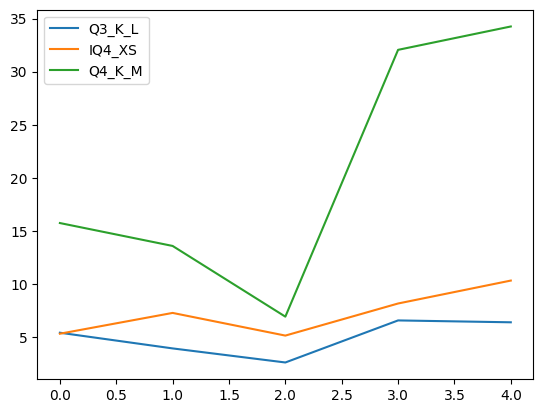

In [46]:
times_df.plot()

As we see from the above plots and datas, all of the models have done a good job in responses except IQ4_XS	that respond weird.

If we ignore this IQ4_XS is the best option. But let's go one step further and embedd the answers to check how close they are to each other.

we use nomic-embed-text v1.5 and in the previous notebook we find out how good Q5_K_M really is.

In [53]:
from openai import OpenAI
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

def get_embedding(text, model="nomic-ai/nomic-embed-text-v1.5-GGUF"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [72]:
import numpy as np

embedded_answers = {}

for key, value in llm_quantizations_datas.items():
    embedds = []
    for answer in value[1]:
        embedding = np.array([get_embedding(answer)])
        embedds.append(embedding)

    embedded_answers[key] = embedds

In [73]:
gpt_answers = {"answer": [value["answer"] for value in gpt_data.values()]}

gpt_embedded_answers = []
for answer in gpt_answers["answer"]:
    embedding = np.array([get_embedding(answer)])
    gpt_embedded_answers.append(embedding)

Now we want to find out the similarity between answers and models responds using Cosine similarity.

In [79]:
from sklearn.metrics.pairwise import cosine_similarity


similarities = {}

for model_name in embedded_answers.keys():
    gpt_similarity_to_model = []
    for answer_index in range(len(gpt_embedded_answers)):
        similarity = cosine_similarity(gpt_embedded_answers[answer_index], embedded_answers[model_name][answer_index])

        gpt_similarity_to_model.append(similarity[0][0])

    similarities[model_name] = gpt_similarity_to_model

In [83]:
similarities_df = pd.DataFrame(similarities)
similarities_df

,Q3_K_L,IQ4_XS,Q4_K_M
0,0.989481,0.989481,0.879064
1,0.992850,0.992850,0.992850
2,0.988751,0.988751,0.988751
3,1.000000,1.000000,0.991296
4,0.847353,0.806914,0.870100


<Axes: >

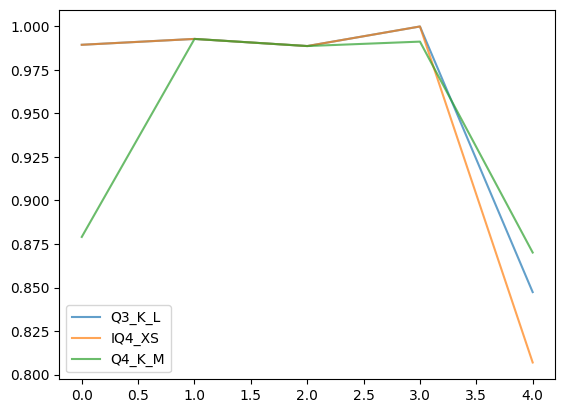

In [95]:
similarities_df.plot(alpha=0.7)